In [1]:
%load_ext autoreload
%autoreload 2

import copy
import math
from typing import Any, List, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.vq
import scipy.spatial
from matplotlib import collections as mc


C:\Users\JasonGauci\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JasonGauci\miniconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\JasonGauci\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    retval = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return retval


def create_sub_system(center):
    points = np.random.randn(100, 2)
    # Kill extreme points
    points = points[np.amax(points, axis=1) <= 3]
    points = points[np.amin(points, axis=1) >= -3]

    centroids, _ = scipy.cluster.vq.kmeans(
        points, 6, iter=100, thresh=1e-05, check_finite=True
    )
    centroids += center
    return centroids

def create_spatial_graph():
    points = np.vstack(
        [create_sub_system([x, y]) for x in range(0, 16, 4) for y in range(0, 16, 4)]
    )

    tri = scipy.spatial.Delaunay(points)

    # create a set for edges that are indexes of the points
    edges: Set[Tuple[int, int]] = set()
    for n in range(tri.nsimplex):
        # Skip triangles that are too thin
        skip = False
        for x in range(3):
            if (
                angle_between(
                    points[tri.vertices[n, x]] - points[tri.vertices[n, (x + 1) % 3]],
                    points[tri.vertices[n, (x + 2) % 3]]
                    - points[tri.vertices[n, (x + 1) % 3]],
                )
                < math.pi / 10
            ):
                skip = True
        if skip:
            continue
        edge = sorted([tri.vertices[n, 0], tri.vertices[n, 1]])
        edges.add((edge[0], edge[1]))
        edge = sorted([tri.vertices[n, 0], tri.vertices[n, 2]])
        edges.add((edge[0], edge[1]))
        edge = sorted([tri.vertices[n, 1], tri.vertices[n, 2]])
        edges.add((edge[0], edge[1]))

    trimmed_edges = []
    for edge in list(edges):
        line = (points[edge[0]], points[edge[1]])
        dist = scipy.spatial.distance.euclidean(line[0], line[1])
        if dist < 2.0:
            trimmed_edges.append(edge)

    min_point = list(points[0])
    for point in points:
        min_point[0] = min(point[0], min_point[0])
        min_point[1] = min(point[1], min_point[1])

    scaled_int_points = []
    for point in points:
        scaled_int_points.append(
            (
                int((point[0] - min_point[0] + 1.0) * 100),
                int((point[1] - min_point[1] + 1.0) * 100),
            )
        )
    return (scaled_int_points, trimmed_edges)


In [3]:
import networkx as nx

np.random.seed(2)


points, edges = create_spatial_graph()
points_dict = dict([(idx, p) for idx,p in enumerate(points)])
np_points = np.vstack(points)


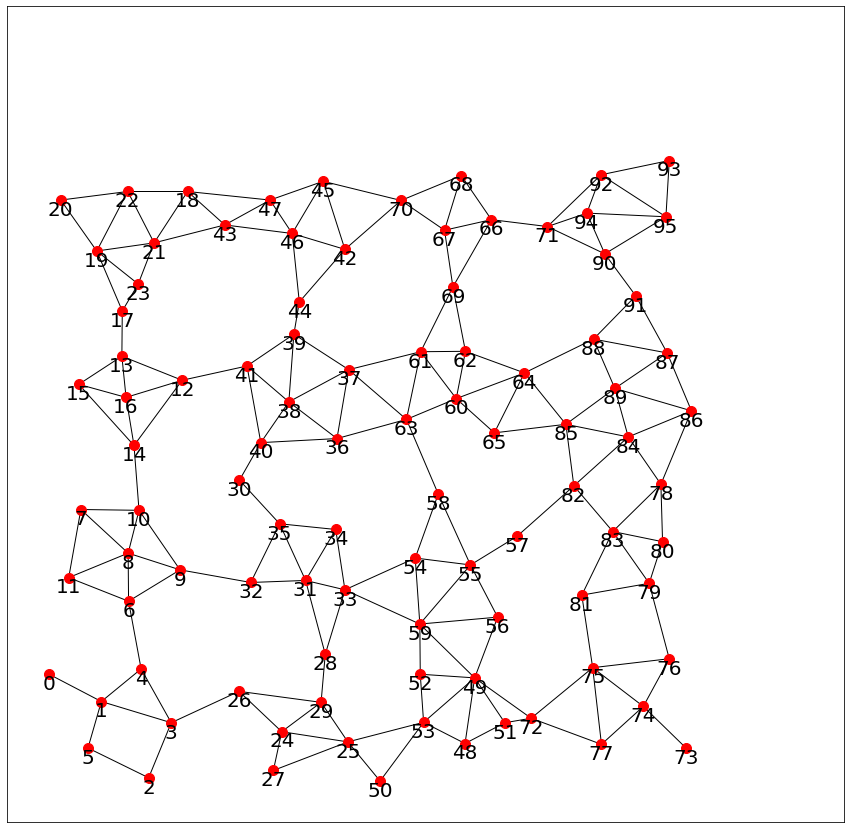

In [4]:
map_graph=nx.Graph()
map_graph.add_edges_from(edges)

draw_params = {
    "node_size":100,
    "font_size":20,
    "node_color":"r",
    "verticalalignment":'top',
}

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_xlim((0,2000))
ax.set_ylim((0,2000))
nx.draw_networkx(map_graph, pos=np_points, ax=ax, **draw_params)


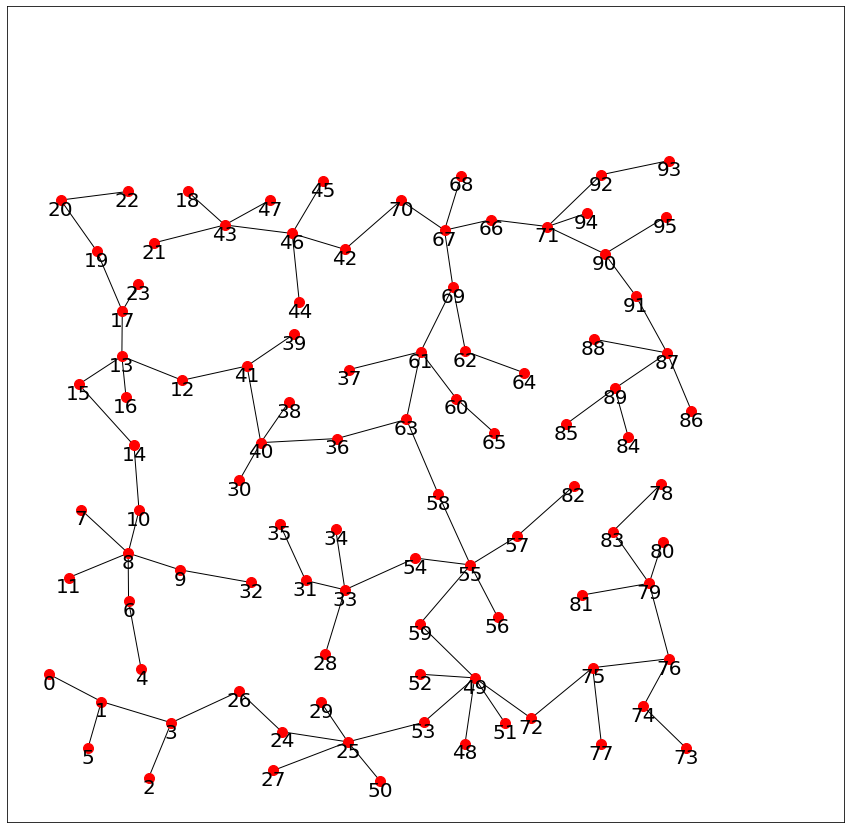

In [5]:
spanning_tree=nx.minimum_spanning_tree(map_graph)

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_xlim((0,2000))
ax.set_ylim((0,2000))
nx.draw_networkx(spanning_tree, pos=np_points, ax=ax, **draw_params)


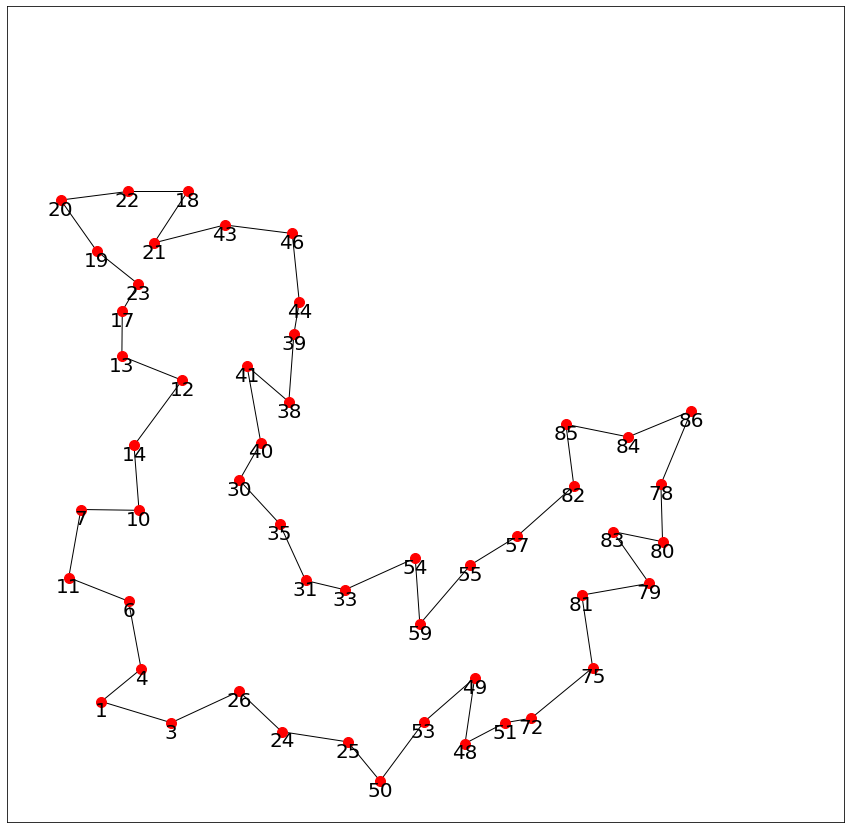

In [6]:
chain_edges=list(nx.chain_decomposition(map_graph, root=0))
chain_graph = nx.Graph()
chain_graph.add_edges_from(chain_edges[0])

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_xlim((0,2000))
ax.set_ylim((0,2000))
nx.draw_networkx(chain_graph, pos=np_points, ax=ax, **draw_params)


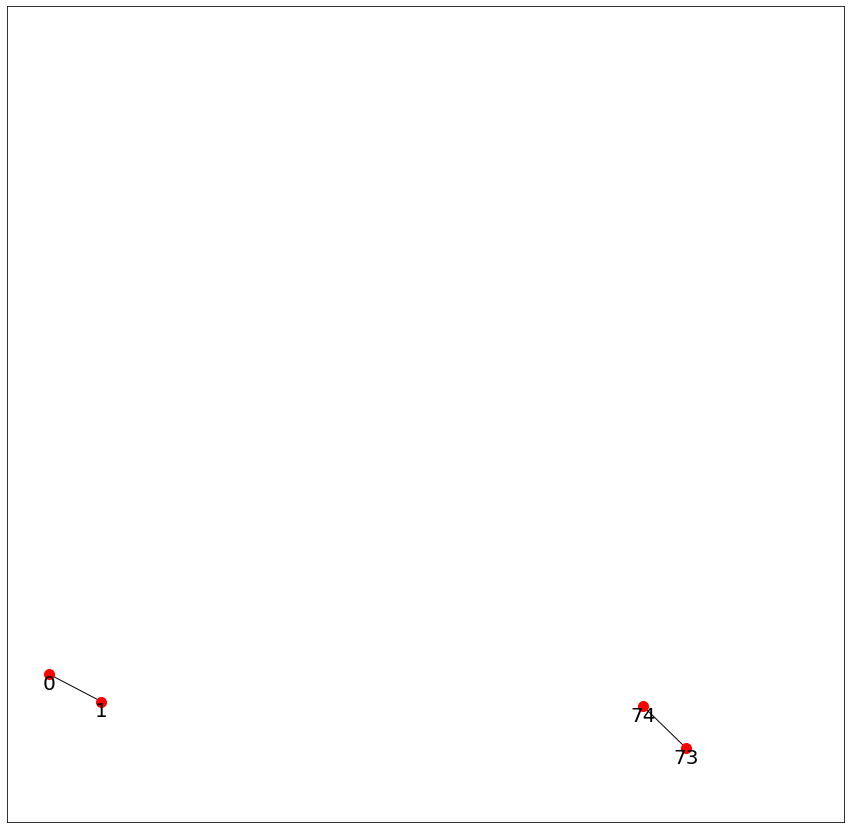

In [7]:
bridge_edges=list(nx.bridges(map_graph, root=0))
bridge_graph = nx.Graph()
bridge_graph.add_edges_from(bridge_edges)

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_xlim((0,2000))
ax.set_ylim((0,2000))
nx.draw_networkx(bridge_graph, pos=np_points, ax=ax, **draw_params)


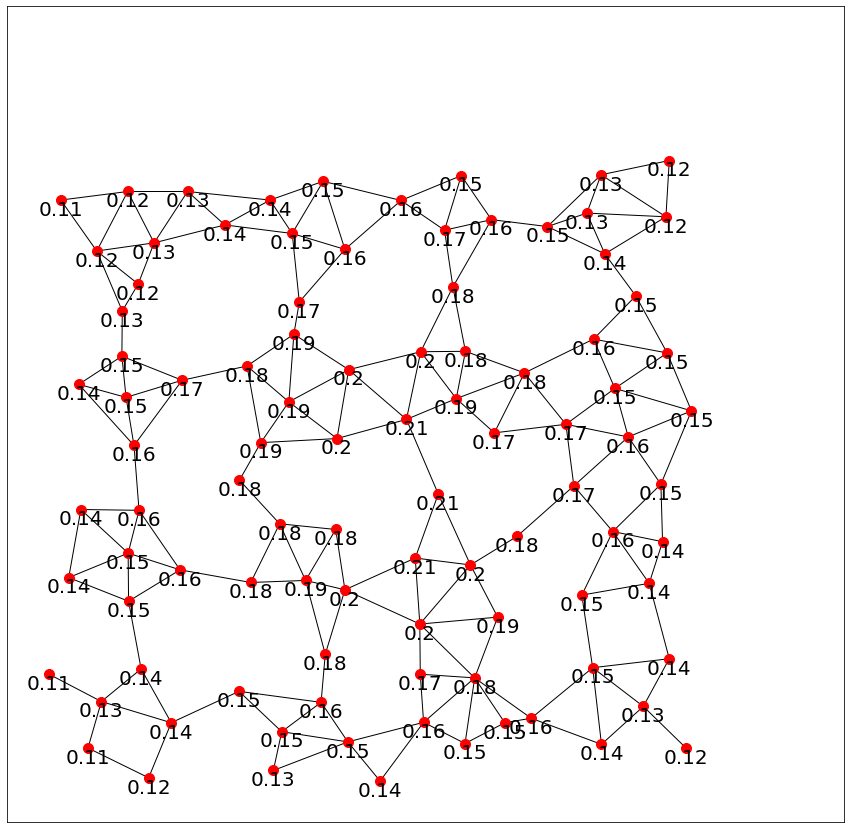

In [8]:
node_centrality=nx.closeness_centrality(map_graph)
node_centrality = dict([(k,round(v,2)) for k,v in node_centrality.items()])

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_xlim((0,2000))
ax.set_ylim((0,2000))
nx.draw_networkx(map_graph, pos=np_points, labels=node_centrality, ax=ax, **draw_params)


1.0
{55: {57: 0, 59: 0, 56: 0, 58: 0, 54: 0}, 57: {55: 0, 82: 0}, 67: {68: 0, 70: 0, 69: 0, 66: 0}, 68: {67: 0, 70: 0, 66: 0}, 43: {46: 0, 21: 0, 18: 0, 47: 0}, 46: {43: 0, 45: 0, 47: 0, 44: 0, 42: 0}, 33: {54: 0, 31: 0, 28: 0, 59: 0, 34: 0}, 54: {33: 0, 58: 0, 55: 0, 59: 0}, 87: {89: 0, 91: 0, 86: 0, 88: 0}, 89: {87: 0, 86: 0, 88: 0, 84: 0, 85: 0}, 25: {50: 0, 27: 0, 29: 0, 24: 0, 53: 1.0}, 50: {25: 0, 53: 0}, 8: {9: 0, 11: 0, 6: 0, 10: 0, 7: 0}, 9: {8: 0, 10: 0, 32: 0, 6: 0}, 40: {41: 0, 30: 0, 36: 0, 38: 0}, 41: {40: 0, 38: 0, 39: 0, 12: 0}, 49: {53: 0, 48: 0, 59: 0, 52: 0, 56: 0, 72: 1.0, 51: 0}, 53: {49: 1.0, 48: 0, 52: 0, 50: 0, 25: 0}, 66: {69: 0, 71: 0, 68: 0, 67: 0}, 69: {66: 0, 62: 0, 61: 0, 67: 0}, 76: {79: 0, 75: 0, 74: 0}, 79: {76: 0, 81: 0, 83: 0, 80: 0}, 75: {81: 0, 72: 0, 74: 1.0, 76: 0, 77: 0}, 81: {75: 0, 79: 0, 83: 0}, 13: {17: 0, 12: 0, 16: 0, 15: 0}, 17: {13: 0, 23: 0, 19: 0}, 6: {11: 0, 4: 0, 8: 0, 9: 0}, 11: {6: 0, 8: 0, 7: 0}, 7: {10: 0, 11: 0, 8: 0}, 10: {7: 0,

{(25, 53): Text(904.5, 220.0, '1'),
 (49, 72): Text(1184.5, 303.5, '1'),
 (53, 49): Text(1056.0, 298.5, '1'),
 (75, 74): Text(1459.5, 330.5, '1'),
 (24, 25): Text(735.0, 208.5, '1'),
 (26, 24): Text(605.0, 270.5, '1'),
 (72, 75): Text(1325.5, 316.0, '1'),
 (74, 73): Text(1571.0, 232.0, '1'),
 (3, 26): Text(473.0, 281.5, '1'),
 (1, 3): Text(308.5, 269.0, '1'),
 (0, 1): Text(162.5, 328.5, '1')}

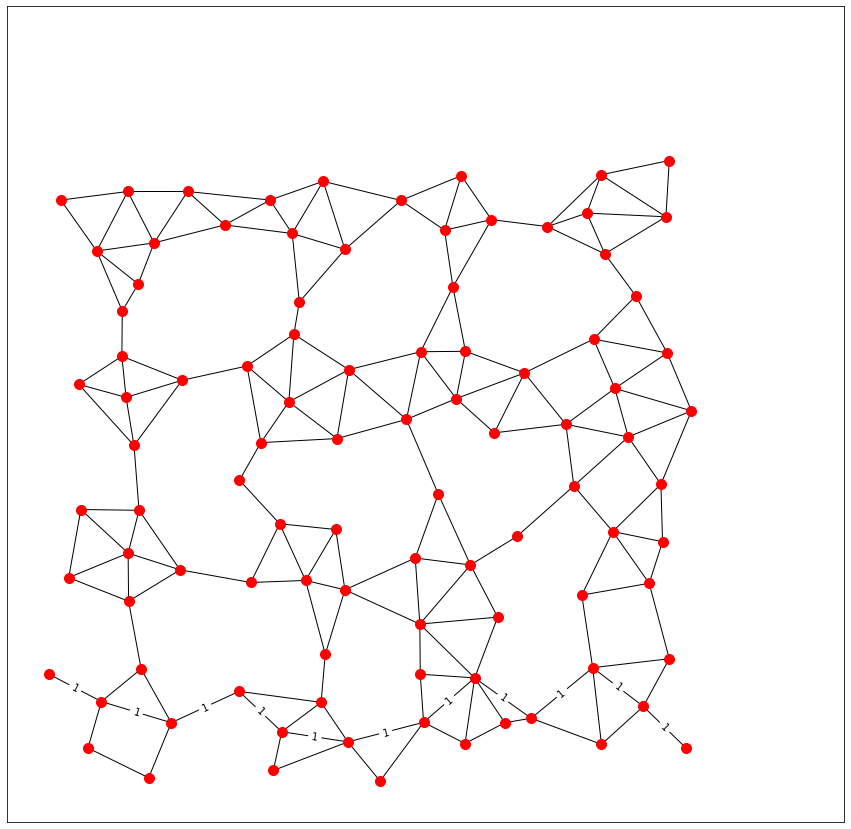

In [9]:
graph_with_flow = copy.deepcopy(map_graph)
nx.set_edge_attributes(graph_with_flow, 1.0, "capacity")
max_flow, max_flow_per_edge=nx.maximum_flow(graph_with_flow, 0, 73)
print(max_flow)
print(max_flow_per_edge)

edge_labels = {}
for source, dest_flow_pairs in max_flow_per_edge.items():
    for destination, flow in dest_flow_pairs.items():
        if flow > 0:
            edge_labels[(source, destination)] = int(flow)

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_xlim((0,2000))
ax.set_ylim((0,2000))
nx.draw_networkx(map_graph, pos=np_points, with_labels=False, ax=ax, **draw_params)
nx.draw_networkx_edge_labels(map_graph, pos=np_points, edge_labels=edge_labels)


{(33, 59): Text(896.5, 527.0, '1'),
 (25, 53): Text(904.5, 220.0, '1'),
 (9, 32): Text(497.5, 602.5, '1'),
 (49, 72): Text(1184.5, 303.5, '1'),
 (49, 51): Text(1153.0, 298.0, '1'),
 (53, 49): Text(1056.0, 298.5, '1'),
 (75, 74): Text(1459.5, 330.5, '1'),
 (6, 9): Text(351.5, 579.5, '1'),
 (24, 25): Text(735.0, 208.5, '1'),
 (26, 24): Text(605.0, 270.5, '1'),
 (72, 75): Text(1325.5, 316.0, '1'),
 (72, 77): Text(1336.0, 222.0, '1'),
 (59, 49): Text(1051.5, 419.0, '1'),
 (77, 74): Text(1470.0, 236.5, '1'),
 (31, 33): Text(760.0, 580.5, '1'),
 (3, 26): Text(473.0, 281.5, '1'),
 (51, 72): Text(1220.5, 248.5, '1'),
 (1, 3): Text(308.5, 269.0, '1'),
 (1, 4): Text(272.5, 335.0, '1'),
 (4, 6): Text(305.0, 458.0, '1'),
 (32, 31): Text(647.5, 589.5, '1')}

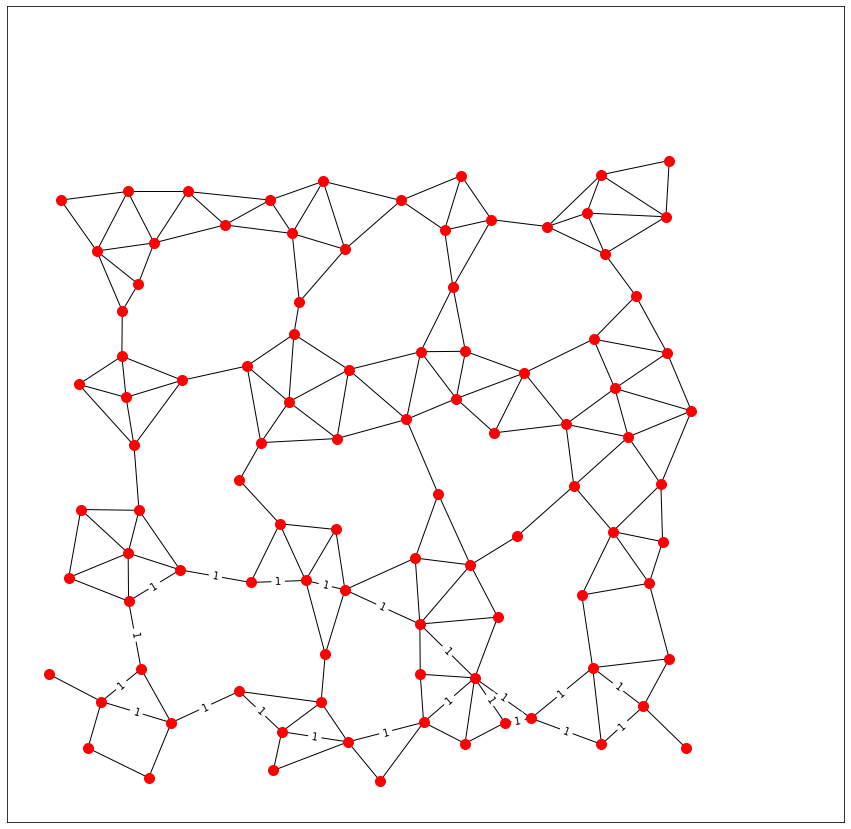

In [10]:
graph_with_flow = copy.deepcopy(map_graph)
nx.set_edge_attributes(graph_with_flow, 1.0, "capacity")
max_flow, max_flow_per_edge=nx.maximum_flow(graph_with_flow, 1, 74)

edge_labels = {}
for source, dest_flow_pairs in max_flow_per_edge.items():
    for destination, flow in dest_flow_pairs.items():
        if flow > 0:
            edge_labels[(source, destination)] = int(flow)

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_xlim((0,2000))
ax.set_ylim((0,2000))
nx.draw_networkx(map_graph, pos=np_points, with_labels=False, ax=ax, **draw_params)
nx.draw_networkx_edge_labels(map_graph, pos=np_points, edge_labels=edge_labels)
